In [78]:
import pandas as pd

import sys
sys.path.append(r"C:\Pro\Stages\A4 - DVRC\Work\Supervised-Learning-using-Unsupervised-Learning-Metrics-in-the-absence-of-Annotated-Data\myLibraries")
from MARScore.utils import *
from MARScore.score import MARSCore

from sklearn.feature_extraction.text import TfidfVectorizer
from custom_score.utils import cleanString

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nltk.stem import PorterStemmer

### TF-IDF Spatial Distribution 

#### Dataset loading

In [114]:
dataset = pd.read_json(r'C:\Pro\Stages\A4 - DVRC\Work\Datasets\pubmed\test.json', lines=True)
dataset = dataset[["article_text", "abstract_text"]]
cleaner = lambda x: ". ".join(x).replace("<S>", "").strip()
format_dot = lambda x: x.replace(" .", ".")
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].replace(regex=r"\[[^\]]*\]", value="")
dataset.loc[:,"article_text"] = dataset["article_text"].replace(regex=r"\[[^\]]*\]", value="")
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(cleaner)
dataset.loc[:,"article_text"] = dataset["article_text"].map(cleaner)
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(cleanString)
dataset.loc[:,"article_text"] = dataset["article_text"].map(cleanString)
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(format_dot)
dataset.loc[:,"article_text"] = dataset["article_text"].map(format_dot)
dataset = dataset.rename(columns={"abstract_text": "summary",
                        "article_text": "text"})

subset = dataset.iloc[1, :]

#### Embedding extraction

In [115]:
o, l = tokenizeCorpus(subset["text"])
v = vectorizeCorpus(o, method="concat_l4")
v, l = cleanAll(v, l)

#### Stemming

In [116]:
ps = PorterStemmer()
stemmed_l = [ps.stem(token) for token in l]
stemmed_l
avg_vectors = {}
for stem, vector in zip(stemmed_l, v):
    avg_vectors.setdefault(stem, []).append(vector)
for key, value in avg_vectors.items():
    avg_vectors[key] = np.median(value, axis=0)
stemmed_v = [avg_vectors[token] for token in stemmed_l]

#### TI-IDF Calculation

In [117]:
def tfidf(text):
    """
    Computes individual TFs of tokens.

    :param1 text (list): List of tokens.

    :output tf_dict (dict): Dictionnary of tokens with their corresponding IDF.
    """
    vectorizer = TfidfVectorizer(use_idf=True, norm=None, tokenizer=lambda x: x, lowercase=False, token_pattern=None)
    tfidf_values = vectorizer.fit_transform([text]).toarray()[0]
    tfidf_dict = {word: tfidf_values[index] for word, index in vectorizer.vocabulary_.items()}
    return tfidf_dict

In [118]:
l_tfidf = tfidf(stemmed_l)
l_tfidf

{'small': 14.0,
 'non': 16.0,
 'code': 13.0,
 'rna': 16.0,
 '##': 23.0,
 'are': 15.0,
 'transcrib': 4.0,
 'into': 3.0,
 'mrna': 4.0,
 'but': 2.0,
 'remain': 3.0,
 '##tra': 1.0,
 '##n': 5.0,
 '##late': 3.0,
 '##kar': 1.0,
 '##yo': 1.0,
 '##tic': 2.0,
 'cell': 65.0,
 '.': 112.0,
 'they': 2.0,
 'includ': 9.0,
 'sir': 1.0,
 '##na': 61.0,
 'interf': 1.0,
 'mir': 106.0,
 'micro': 2.0,
 '##rna': 6.0,
 '##wi': 2.0,
 'interact': 2.0,
 'and': 97.0,
 '##nor': 4.0,
 '##cle': 1.0,
 '##olar': 1.0,
 'class': 1.0,
 'multi': 1.0,
 '##fu': 2.0,
 '##nction': 1.0,
 '##al': 4.0,
 'singl': 1.0,
 'strand': 1.0,
 'which': 7.0,
 'length': 1.0,
 'regul': 25.0,
 'the': 92.0,
 'stabil': 1.0,
 'translat': 2.0,
 'effici': 1.0,
 'target': 13.0,
 'messeng': 1.0,
 'depend': 2.0,
 'base': 5.0,
 'pair': 1.0,
 'complement': 1.0,
 '##ari': 2.0,
 '##ti': 1.0,
 'between': 4.0,
 'it': 1.0,
 'although': 4.0,
 'over': 6.0,
 '000': 3.0,
 'sequenc': 4.0,
 'have': 7.0,
 'been': 10.0,
 'identifi': 6.0,
 'from': 6.0,
 'tissu': 4.0,

#### Dimension reduction

In [119]:
umap2D = deserialize(r"C:\Pro\Stages\A4 - DVRC\Work\Ressources\umap2D.pkl")
v_2D = umap2D.fit_transform(stemmed_v)
np.array(v_2D).shape

x = [coord[0] for coord in v_2D]
y = [coord[1] for coord in v_2D]

#### Testing Plots

In [120]:
data = {"x": x,
        "y": y,
        "v": l_tfidf}

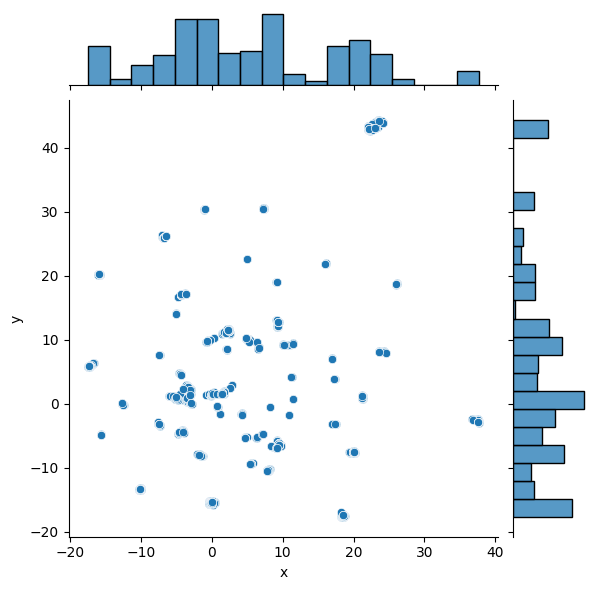

In [121]:
sns.jointplot(data=data, x="x", y="y", kind="scatter")

#### Final Plots

In [122]:
x = [coord[0] for coord in v_2D]
y = [coord[1] for coord in v_2D]

l_tfidf = tfidf(l)
l_tfidf_list = [l_tfidf[token] for token in l]

x_tfs = [[cur_x, cur_tfidf] for cur_x, cur_tfidf in zip(x, l_tfidf_list)]
x_tfs.sort(key=lambda x: x[0])

y_tfs = [[cur_y, cur_tfidf] for cur_y, cur_tfidf in zip(y, l_tfidf_list)]
y_tfs.sort(key=lambda y: y[0])

In [124]:
def scatter_hist(x, y, vx, vy, ax, ax_barx, ax_bary):
    # no labels
    ax_barx.tick_params(axis="x", labelbottom=False)
    ax_bary.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)
    #ax.set_title("TF-IDF spatial distribution", pad=20)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    # now determine nice limits by hand:
    binwidth = 0.2
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_barx.bar([val[0] for val in vx], [val[1] for val in vx], width=binwidth)
    ax_bary.barh([val[0] for val in vy], [val[1] for val in vy], height=binwidth)

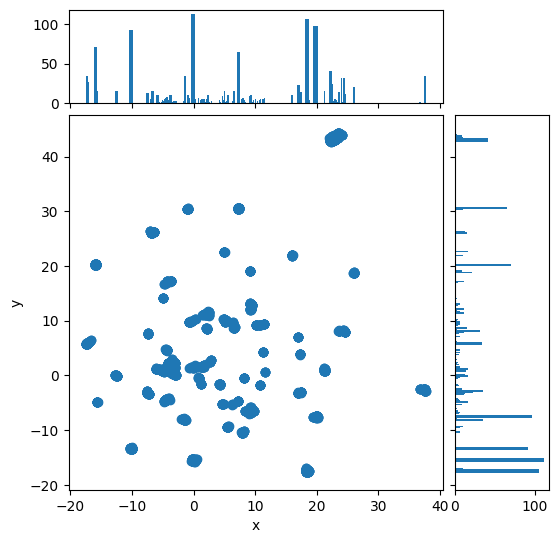

In [125]:
# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_barx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_bary = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(x, y, x_tfs, y_tfs, ax, ax_barx, ax_bary)